# **Proyek Klasifikasi Gambar: Klasifikasi Kantung Sampah**

- Nama: Jessindy Tanuwijaya
- Email: tanjess676@gmail.com
- ID Dicoding: jessdytan
- Dataset: https://www.kaggle.com/datasets/vencerlanz09/plastic-paper-garbage-bag-synthetic-images

## 1. Import Library/Packages

In [ ]:
# Library Sistem dan File Handling
import os                         # Operasi sistem file & direktori
import shutil                     # Menyalin dan memindahkan file
import zipfile                    # Ekstrak file ZIP
import io                         # Operasi I/O berbasis memori
from pathlib import Path          # Representasi path file/direktori

# Operasi Numerik & Data
import numpy as np                # Operasi numerik array/matriks
import pandas as pd               # Manipulasi data tabular

# Visualisasi Data
import matplotlib.pyplot as plt   # Visualisasi dasar
import seaborn as sns             # Visualisasi statistik

# Pemrosesan Gambar & Interaksi
from PIL import Image                       # Pemrosesan gambar (buka, ubah ukuran, dll)
import random                               # Operasi acak (shuffle, random choice)
from IPython.display import display         # Menampilkan output/gambar dalam notebook
import ipywidgets as widgets                # Widget interaktif (sliders, tombol, dll)
from tqdm.notebook import tqdm              # Progress bar untuk loop

# Machine Learning & Preprocessing
from sklearn.model_selection import train_test_split  # Membagi dataset jadi train/test
from sklearn.metrics import confusion_matrix          # Evaluasi model klasifikasi

# Deep Learning (TensorFlow)
import tensorflow as tf
from tensorflow.keras import layers, models                               # Layer & Model dari Keras
from tensorflow.keras.preprocessing import image                          # Pemrosesan gambar untuk model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau   # Callback saat training

# TensorFlow JS (Optional jika ekspor model ke web)
import tensorflowjs as tfjs        # Untuk ekspor model ke format TensorFlow.js (digunakan untuk web)


In [ ]:
print(tf.__version__)

# Uncomment perintah di bawah jika versi tensorflow Anda di bawah ini
# !pip install tensorflow==2.18

2.18.0


## 2. Accessing Data

### 2.1 Download and Extract Dataset From Kaggle

Langkah-langkah untuk Mendapatkan kaggle.json:
1. Login ke Kaggle:
  
  Pergi ke Kaggle dan login menggunakan akun kamu. Jika belum punya akun, Anda bisa mendaftar terlebih dahulu.

2. Buka Halaman Akun Anda:
  
  Setelah login, klik ikon profil di sudut kanan atas halaman, kemudian pilih "**My Account**" dari dropdown menu.

3. Scroll ke Bagian API:
  
  Di halaman "Account", scroll ke bawah sampai menemukan bagian yang bernama "API". Di bagian ini ada tombol "**Create New API Token**". Klik tombol tersebut untuk membuat token API baru.

4. Download kaggle.json:

  Setelah klik tombol "Create New API Token", file kaggle.json akan otomatis diunduh ke komputer Anda.File ini berisi dua informasi penting: username dan key, yang akan digunakan untuk mengakses Kaggle API.





In [ ]:
from google.colab import files, userdata
# upload kaggle.json
files.upload()

Fungsi drive.mount('/content/drive') digunakan untuk menghubungkan Google Colab dengan Google Drive. Dengan melakukan mount Google Drive, kamu bisa mengakses file yang ada di Google Drive secara langsung dari Google Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Kode di bawah bertujuan untuk menyiapkan kredensial API Kaggle dengan cara memindahkan file kaggle.json ke folder yang tepat di Google Colab, sehingga API Kaggle dapat digunakan untuk mengakses dataset atau model secara otomatis dan aman.

In [ ]:
# Buat folder .kaggle di home directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Pindahkan kaggle.json ke folder tersebut
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')

# Ubah permission supaya hanya bisa dibaca oleh user
os.chmod('/root/.kaggle/kaggle.json', 600)

Setelah menjalankan perintah dibawah ini, file zip dataset akan diunduh ke direktori kerja saat ini di Google Colab. Anda dapat mengekstrak dan menggunakannya untuk proyek Anda.

In [ ]:
!kaggle datasets download -d vencerlanz09/plastic-paper-garbage-bag-synthetic-images

Dataset URL: https://www.kaggle.com/datasets/vencerlanz09/plastic-paper-garbage-bag-synthetic-images
License(s): CC-BY-SA-4.0


Mengekstrak seluruh isi file zip ke dalam folder dataset. Folder ini akan dibuat secara otomatis jika belum ada.

In [ ]:
with zipfile.ZipFile("plastic-paper-garbage-bag-synthetic-images.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

Mengambil dan mengorganisir gambar-gambar dari dataset yang telah diekstrak, berdasarkan kategori yang berbeda (Garbage Bag, Paper Bag, dan Plastic Bag), serta menghitung jumlah gambar yang tersedia di setiap kategori.

In [ ]:
# Base directory path ke folder yang berisi kategori gambar
base_dir = Path('dataset/Bag Classes/Bag Classes')

# Fungsi ini akan mencari semua path gambar berdasarkan kategori yang diberikan
def get_image_paths(category):
    folder = base_dir / category  # Menyusun path folder berdasarkan kategori
    return [
        folder / f for f in os.listdir(folder)  # Mengambil semua file dalam folder
        if f.lower().endswith(('jpg', 'jpeg', 'png'))  # Memastikan file adalah gambar
    ]

# Mendapatkan path lengkap gambar untuk masing-masing kategori
garbage_image_paths = get_image_paths('Garbage Bag Images')  # Mendapatkan gambar kantong sampah
paper_image_paths = get_image_paths('Paper Bag Images')  # Mendapatkan gambar kantong kertas
plastic_image_paths = get_image_paths('Plastic Bag Images')  # Mendapatkan gambar kantong plastik

# Menampilkan jumlah gambar yang terdeteksi untuk masing-masing kategori
print(f"Jumlah gambar Garbage Bag (Kantong Sampah): {len(garbage_image_paths)}")  # Menampilkan jumlah gambar kantong sampah
print(f"Jumlah gambar Paper Bag (Kantong Kertas): {len(paper_image_paths)}")  # Menampilkan jumlah gambar kantong kertas
print(f"Jumlah gambar Plastic Bag (Kantong Plastik): {len(plastic_image_paths)}")  # Menampilkan jumlah gambar kantong plastik

Jumlah gambar Garbage Bag (Kantong Sampah): 5000
Jumlah gambar Paper Bag (Kantong Kertas): 5000
Jumlah gambar Plastic Bag (Kantong Plastik): 5000


### 2.2 Data Preproccessing

Membagi dataset gambar yang ada ke dalam tiga bagian utama: `train`, `validation`, dan `test` berdasarkan rasio pembagian yang diberikan **(80% train, 10% validation, 10% test)**. Kemudian, gambar-gambar tersebut dipindahkan ke folder masing-masing sesuai dengan kategori (kelas) mereka.



In [ ]:
# Fungsi untuk membagi dataset ke dalam tiga bagian: train, val, dan test
def split_dataset(dataset_path, base_output, split_ratio=(0.8, 0.1, 0.1)):
    # Membuat folder untuk setiap split dan kelas (train, val, test)
    for split in ['train', 'val', 'test']:
        for class_name in os.listdir(dataset_path):  # Melakukan iterasi pada setiap folder kelas
            os.makedirs(os.path.join(base_output, split, class_name), exist_ok=True)  # Membuat folder untuk setiap split

    # Membagi gambar per kelas ke dalam masing-masing split (train, val, test)
    for class_name in os.listdir(dataset_path):
        all_images = os.listdir(os.path.join(dataset_path, class_name))  # Mengambil semua gambar di folder kelas
        random.shuffle(all_images)  # Mengacak urutan gambar
        total = len(all_images)  # Menghitung jumlah gambar
        train_end = int(total * split_ratio[0])  # Menentukan indeks akhir untuk data train
        val_end = train_end + int(total * split_ratio[1])  # Menentukan indeks akhir untuk data val

        # Menyusun split file untuk train, val, dan test
        split_files = {
            'train': all_images[:train_end],  # Gambar untuk data training
            'val': all_images[train_end:val_end],  # Gambar untuk data validation
            'test': all_images[val_end:]  # Gambar untuk data testing
        }

        # Menyalin gambar ke folder yang sesuai
        for split, files in split_files.items():
            for file in files:
                src = os.path.join(dataset_path, class_name, file)  # Sumber file gambar
                dst = os.path.join(base_output, split, class_name, file)  # Tujuan untuk menyalin gambar
                shutil.copyfile(src, dst)  # Menyalin gambar ke folder tujuan

Fungsi load_dataset bertujuan untuk memuat dataset gambar yang telah dipisahkan ke dalam tiga bagian: train, validation, dan test, kemudian mengubah gambar-gambar tersebut menjadi format yang dapat digunakan oleh model TensorFlow. Fungsi ini menggunakan image_dataset_from_directory untuk memuat gambar dengan ukuran yang telah ditentukan dan membaginya dalam batch untuk pelatihan model.

In [ ]:
# Fungsi untuk memuat dataset gambar dari direktori
def load_dataset(base_dir, img_size=(150, 150), batch_size=32):
    # Menggunakan tuple untuk memuat dataset untuk train, val, dan test
    return tuple(
        tf.keras.utils.image_dataset_from_directory(
            os.path.join(base_dir, split),  # Menentukan path ke folder untuk train, val, atau test
            image_size=img_size,  # Mengubah ukuran gambar sesuai img_size
            batch_size=batch_size,  # Menentukan jumlah gambar dalam satu batch
            label_mode='categorical'  # Menggunakan encoding label kategorikal (untuk klasifikasi multi-kelas)
        ) for split in ['train', 'val', 'test']  # Iterasi untuk bagian train, val, dan test
    )

Setelah kedua fungsi berhasil dibuat, saatnya menggunakan kedua fungsi itu, sebelum itu kita akan memisahkan folder` dataset awal` dan `dataset_split` untuk hasil pembagian train,val,test

In [ ]:
base_output = 'dataset_split'
split_ratio = (0.8, 0.1, 0.1)

# Memanggil fungsi untuk membagi dataset
split_dataset(base_dir, base_output, split_ratio)

# Memanggil fungsi untuk memuat dataset yang sudah dibagi
train_ds, val_ds, test_ds = load_dataset(base_output)

# Contoh penggunaan dataset
for images, labels in train_ds.take(1):
    print(images.shape)  # Output: (32, 150, 150, 3)
    print(labels.shape)  # Output: (32, num_classes)

Found 12000 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.
(32, 150, 150, 3)
(32, 3)


Kode dibawah digunakan untuk menampilkan sampel gambar beserta label nya, agar dapat membantu Anda memvisualisasikan beberapa gambar dari dataset yang telah dimuat, sehingga Anda dapat melihat apakah data yang dimuat sesuai dengan yang diinginkan.

In [ ]:
def show_sample_images(dataset, class_names, num_images=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label_idx = np.argmax(labels[i])
            plt.title(class_names[label_idx])
            plt.axis("off")
    plt.tight_layout()
    plt.show()

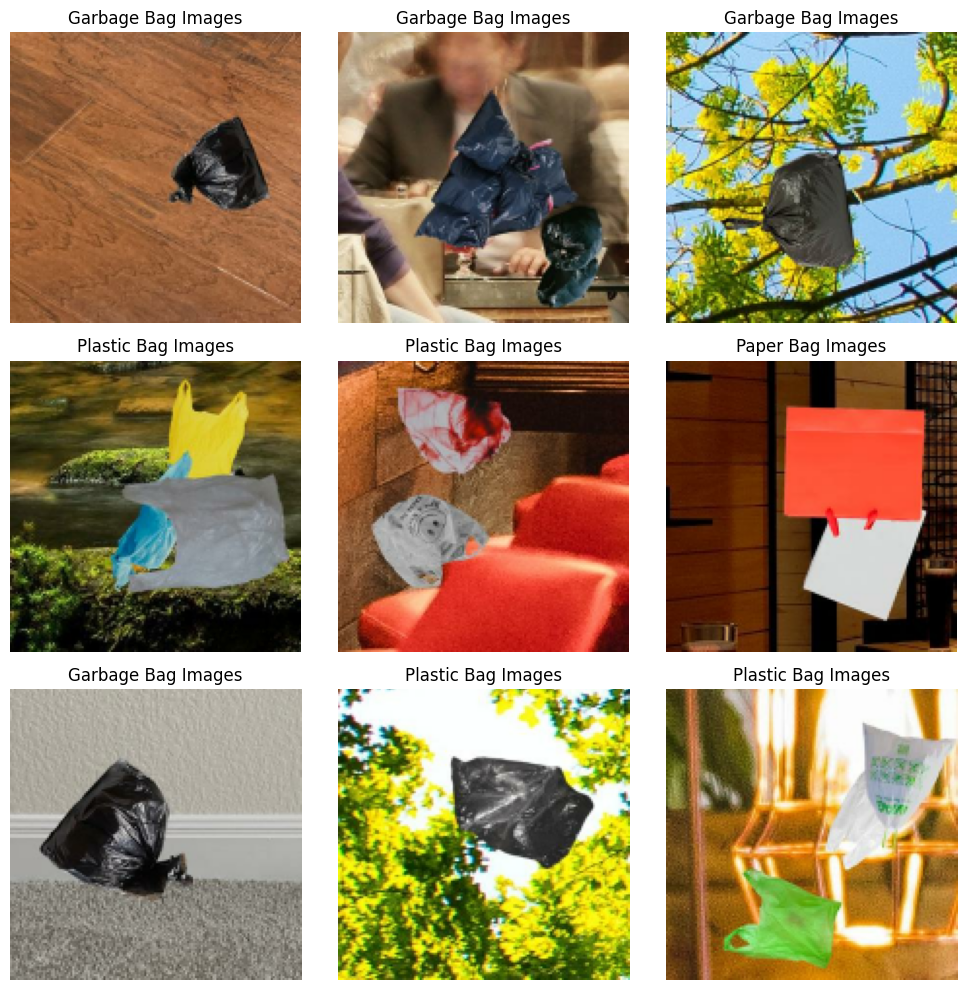

In [ ]:
# Panggil fungsi untuk menampilkan sampel gambar
class_names = train_ds.class_names
show_sample_images(train_ds, class_names)

## 3. Model

Model ini bertujuan untuk mengklasifikasikan gambar ke dalam tiga kategori:

- Garbage Bag Images (Kantong Sampah)
- Paper Bag Images (Kantong Kertas)
- Plastic Bag Images (Kantong Plastik)

Adapun berikut fungsi lapisan nya:
1. Augmentasi dilakukan untuk memperkaya data pelatihan dengan melakukan transformasi acak pada gambar.
2. Konvolusi digunakan untuk mengekstrak fitur dari gambar.
3. Max pooling untuk mengurangi ukuran gambar dan mempertahankan fitur penting.
4. Flattening untuk merubah output 2D ke 1D agar dapat diproses oleh lapisan Dense.
5. Dropout digunakan untuk mencegah overfitting.
6. Output layer dengan 3 unit menggunakan softmax untuk menghasilkan probabilitas untuk setiap kelas.

In [ ]:
# Membuat model CNN
model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),

    # Augmentasi langsung
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),

    layers.Rescaling(1./255),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

Mengompilasi model CNN dengan memilih optimasi, fungsi loss, dan metrik evaluasi yang sesuai:

1. Menggunakan algoritma Adam untuk optimasi, dengan learning rate rendah agar pembelajaran berjalan stabil.
2. Menggunakan categorical crossentropy sebagai fungsi loss yang sesuai untuk masalah klasifikasi multi-kelas.
3. Memantau akurasi selama pelatihan untuk mengevaluasi kinerja model.

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Menampilkan ringkasan struktur dari model

In [ ]:
# Lihat struktur model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 150, 150, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,739 (18.42 MB)

 Trainable params: 4,828,739 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Mendefinisikan dua teknik callback untuk digunakan selama proses pelatihan model: **EarlyStopping** dan **ReduceLROnPlateau**.

Tujuan dari Callback ini:
1. EarlyStopping mencegah pelatihan berlarut-larut setelah model mencapai titik di mana akurasinya tidak meningkat lagi, sehingga menghemat waktu dan sumber daya.
2. ReduceLROnPlateau menurunkan laju pembelajaran jika model tidak menunjukkan peningkatan pada data validasi, yang memungkinkan model untuk lebih baik mengeksplorasi ruang parameter dan menghindari konvergensi prematur pada solusi suboptimal.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=5,
    mode='max',
    verbose=1
)

Kode di bawah bertujuan untuk menangani masalah class imbalance dengan menggunakan bobot kelas (class_weights) yang dihitung berdasarkan frekuensi masing-masing kelas. Ini memungkinkan model untuk memberikan perhatian lebih kepada kelas yang kurang sering muncul dalam dataset, yang dapat membantu meningkatkan akurasi prediksi untuk kelas yang lebih jarang. Lalu melatih model dengan bobot kelas dan menerapkan callback yang sudah dibuat

In [ ]:
# Mendapatkan nama kelas dari dataset pelatihan
class_names = train_ds.class_names

# Membuat dictionary untuk menghitung jumlah gambar per kelas
class_counts = {class_name: 0 for class_name in class_names}

# Iterasi melalui dataset pelatihan untuk menghitung frekuensi masing-masing kelas
for _, labels in train_ds:
    for label in labels.numpy():
        # Mencari indeks kelas dengan probabilitas tertinggi
        class_idx = np.argmax(label)
        class_counts[class_names[class_idx]] += 1

# Menyiapkan data untuk plotting (mengambil nilai jumlah per kelas)
counts = list(class_counts.values())

# Menghitung bobot kelas berdasarkan frekuensi kemunculannya
# Bobot lebih besar diberikan pada kelas yang lebih sedikit jumlahnya
class_weights = {i: 1.0 / count for i, count in enumerate(counts)}

# Melatih model dengan menggunakan bobot kelas yang telah dihitung
history = model.fit(
    train_ds,  # Dataset pelatihan
    validation_data=val_ds,  # Dataset validasi untuk monitoring selama pelatihan
    epochs=25,  # Jumlah epoch yang diinginkan
    class_weight=class_weights,  # Bobot kelas untuk menangani ketidakseimbangan kelas
    callbacks=[early_stopping, reduce_lr],  # Callback untuk menghentikan pelatihan lebih awal dan mengurangi learning rate jika diperlukan
)

Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.5595 - loss: 2.2145e-04 - val_accuracy: 0.8113 - val_loss: 0.4750 - learning_rate: 1.0000e-04
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - accuracy: 0.8303 - loss: 1.1234e-04 - val_accuracy: 0.8553 - val_loss: 0.3990 - learning_rate: 1.0000e-04
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.8652 - loss: 9.2406e-05 - val_accuracy: 0.8867 - val_loss: 0.3190 - learning_rate: 1.0000e-04
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.8782 - loss: 8.3199e-05 - val_accuracy: 0.8933 - val_loss: 0.3001 - learning_rate: 1.0000e-04
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.8898 - loss: 7.4238e-05 - val_accuracy: 0.9087 - val_loss: 0.2646 - learning_rate: 1.0000e-04
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 11s 30ms/step - accuracy: 0.9024 - loss: 6.7151e-05 - val_accuracy: 0.9073 - val_loss: 0.2399 - learning_rate: 1.0000e-04
Epoch 7/25
375/375 ━━━━━━━━━

## 4. Evaluasi Model

In [ ]:
# Evaluasi model pada train set
train_loss, train_accuracy = model.evaluate(train_ds)

print(f"Train Loss: {train_loss}")
print(f"Train Accuracy: {train_accuracy}")

375/375 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9609 - loss: 0.1216
Train Loss: 0.12166392803192139
Train Accuracy: 0.9612500071525574


In [ ]:
# Evaluasi pada dataset test
test_loss, test_acc = model.evaluate(test_ds)

print(f"Test Loss: {test_loss:.4f}")
print(f"\nTest Accuracy: {test_acc:.4f}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9537 - loss: 0.1475
Test Loss: 0.1527

Test Accuracy: 0.9500


## 5. Visualization

Menampilkan plot akurasi dan loss selama pelatihan

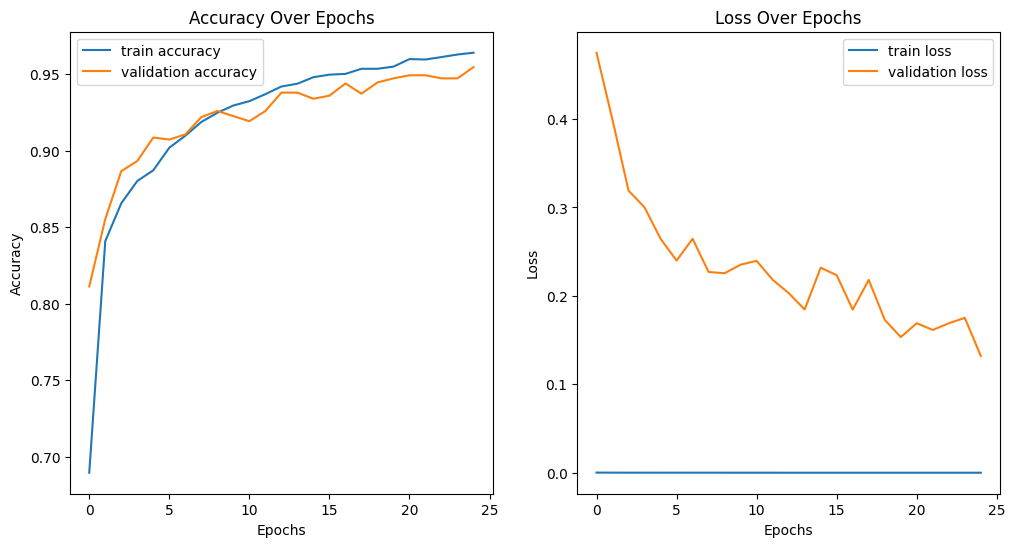

In [ ]:
plt.figure(figsize=(12, 6))

# Plot akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Menampilkan confusion matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━

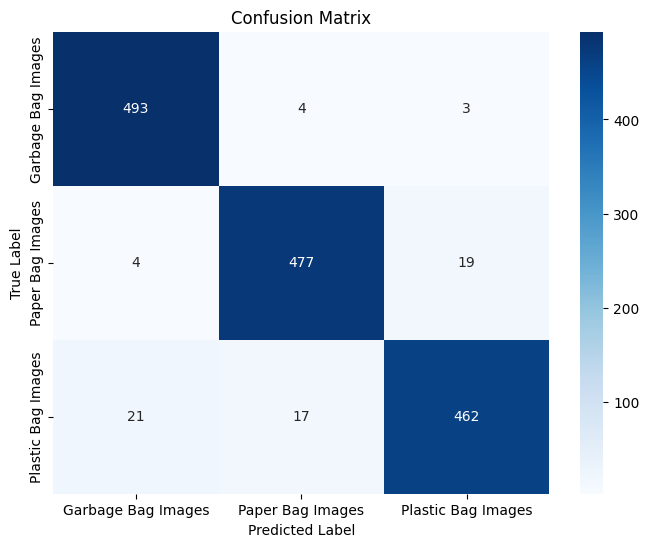

In [ ]:
# Mendapatkan prediksi dari model
y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(np.argmax(labels, axis=1))  # label sebenarnya
    y_pred.extend(np.argmax(model.predict(images), axis=1))  # label hasil prediksi

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_ds.class_names, yticklabels=train_ds.class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## 6. Saving Model

Menyimpan model ke Google Drive dalam format SavedModel

In [ ]:
model.export('/content/drive/My Drive/BPML_KlasifikasiGambar/saved_model')

Saved artifact at '/content/drive/My Drive/BPML_KlasifikasiGambar/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135362693223760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135362693231824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135362693234128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135362606482448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135362606483216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135362606485520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135362606484368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135362606486096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135362606487056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135362606486288: TensorSpec(shape=(), dtyp

Menyimpan model ke Google Drive dalam format tflite

In [ ]:
# Mengkonversi dari format saved_model ke format tflite
converter = tf.lite.TFLiteConverter.from_saved_model("/content/drive/My Drive/BPML_KlasifikasiGambar/saved_model")
converter.experimental_new_converter = True
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS,
  tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()

# Simpan model.tflite
save_dir = "/content/drive/My Drive/BPML_KlasifikasiGambar/tflite"
os.makedirs(save_dir, exist_ok=True)

# Simpan ke Drive
with open(f"{save_dir}/model.tflite", "wb") as f:
    f.write(tflite_model)

# Simpan label.txt jika ada label
labels = ["Garbage Bag Images", "Paper Bag Images", "Plastic Bag Images"] # Sesuai urutan folder
with open(f"{save_dir}/label.txt", "w") as f:
    for label in labels:
        f.write(label + "\n")

Menyimpan model ke Google Drive dalam format tfjs

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [71]:
# Convert it
model.save("model.keras", save_format="keras")
model = load_model("model.keras")
tfjs.converters.save_keras_model(model, "/content/drive/My Drive/BPML_KlasifikasiGambar/tfjs_model")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 22 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


failed to lookup keras version from the file,
    this is likely a weight only file


## 7. Inference (Optional)

Cek Hasil Prediksi dengan gambar validasi

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


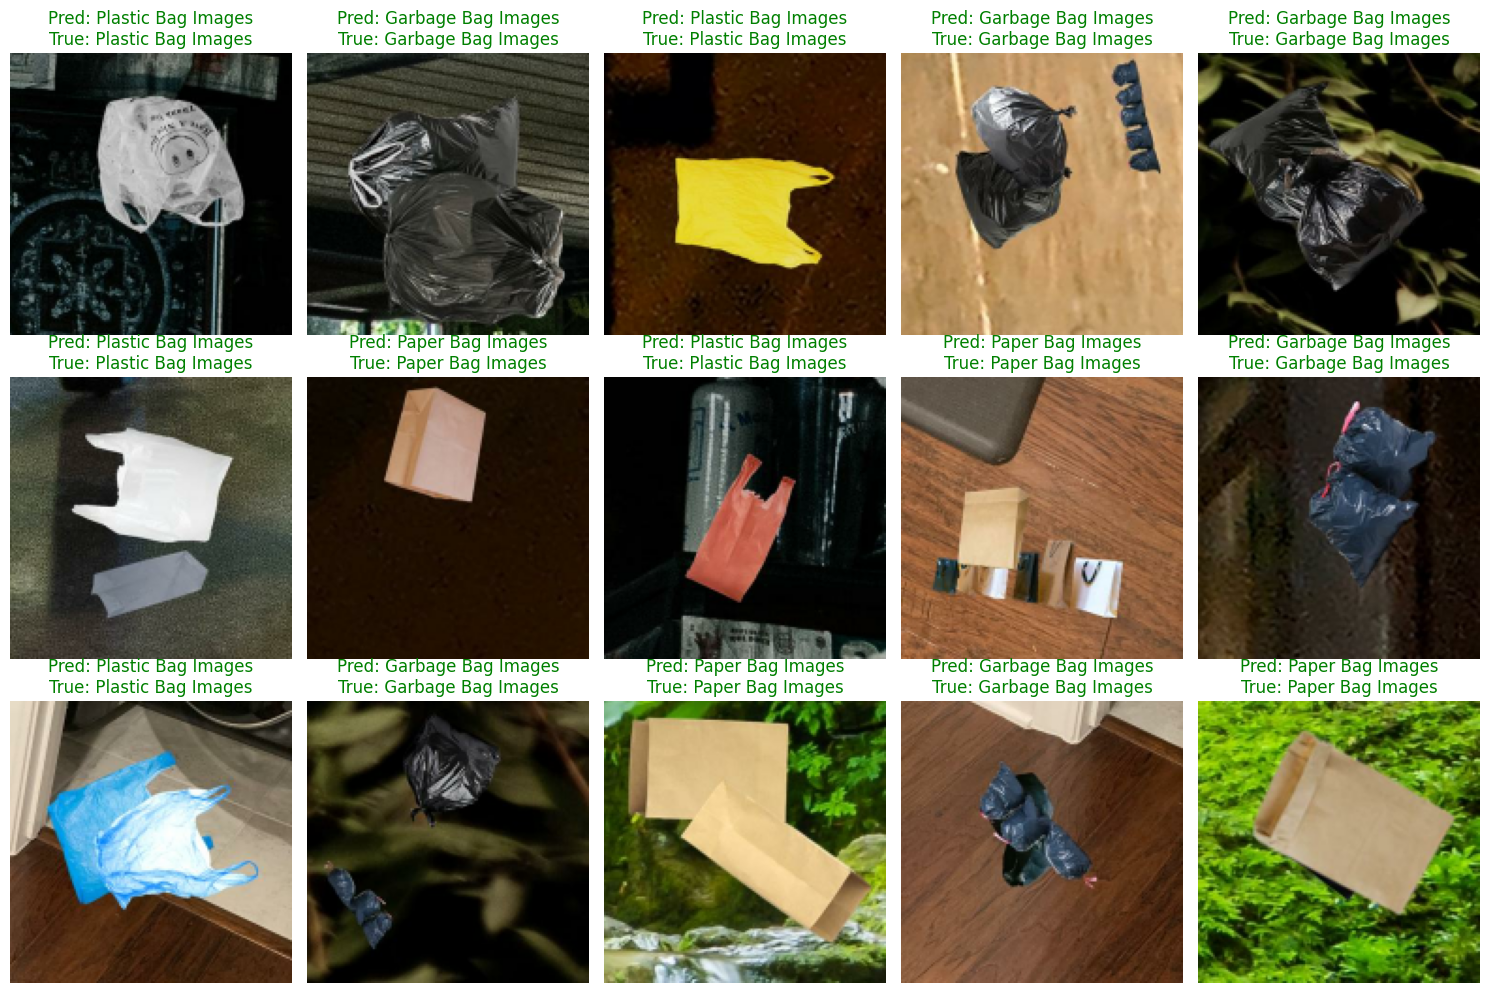

In [ ]:
images, labels = next(iter(val_ds))

# Lakukan prediksi
pred_probs = model.predict(images)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = labels.numpy()

# Class names harus sama dengan train_ds
class_names = train_ds.class_names

# Tampilkan 10 gambar pertama dengan hasil prediksi dan label aslinya
plt.figure(figsize=(15, 10))
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    pred = class_names[pred_labels[i]]
    true = class_names[np.argmax(true_labels[i])]

    color = "green" if pred == true else "red"
    plt.title(f"Pred: {pred}\nTrue: {true}", color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()

Uji coba keakuratan model menggunakan gambar hasil inputan

In [72]:
uploaded = files.upload()  # Upload baru dilakukan di sini

# Ambil nama file terbaru dari upload baru
image_name = list(uploaded.keys())[0]

Saving 6638f90b8cef6131b14b1829-brown-kraft-paper-bags-13x7x17-50ct.png to 6638f90b8cef6131b14b1829-brown-kraft-paper-bags-13x7x17-50ct (6).png


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


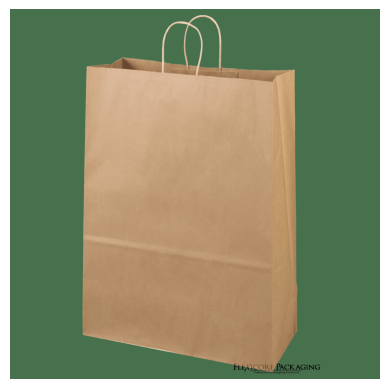

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
Predicted Class: Paper Bag Images
Raw prediction: [[2.2581164e-12 1.0000000e+00 8.0154428e-10]]


In [73]:
def prepare_image(image_path, target_size=(150, 150)):
    img = image.load_img(image_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

img_array = prepare_image(image_name)

# Tampilkan gambar
plt.imshow(image.load_img(image_name))
plt.axis('off')
plt.show()

# Lakukan prediksi
prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=-1)[0]
predicted_class_name = train_ds.class_names[predicted_class]

# Tampilkan hasil
print(f"Predicted Class: {predicted_class_name}")
print(f"Raw prediction: {prediction}")

In [76]:
import pkg_resources

# Daftar library yang memang digunakan di kode kamu
required_libs = [
    "numpy",
    "pandas",
    "matplotlib",
    "seaborn",
    "Pillow",         # PIL
    "ipywidgets",
    "tensorflow",
    "tqdm",
    "scikit-learn",
    "tensorflowjs"
]

# Buat file requirements.txt
with open("requirements.txt", "w") as f:
    for lib in required_libs:
        try:
            version = pkg_resources.get_distribution(lib).version
            f.write(f"{lib}=={version}\n")
        except pkg_resources.DistributionNotFound:
            print(f"Library {lib} tidak ditemukan")

print("✅ requirements.txt berhasil dibuat.")

✅ requirements.txt berhasil dibuat.
